# SRC and HCK Interaction Analysis Pipeline

### 1. Library Imports and Setup

In [1]:
import sys
sys.path.append('./')  # Add current directory to the Python path
sys.path.append('./lib')  # Add 'lib' subdirectory

from calcul import (
    calculate_Kapp,
    get_bait_concentration,
    calculate_complexome,
    log_scale
)

from file_op import (
    extract_species_bait,
    read_csv_file,
    save_csv_file,
    merge_files,
    group_columns_by_species
)

from comparison import (
    calculate_deltapKapp,
    calculate_complexome_difference,
    log_delta,
    calculate_intraspecies_log_complexome_ratio
)

from Venn_diag import (plot_venn_diagram)

from complexome_plot import (plot_complexome_analysis)

from lin_reg import (analyze_and_plot_correlation)

### 2. Data loading and complexome analysis for each bait

In [ ]:
#Human SRC
filepath = "input/human_src_data.csv"
output_path = "output/human_src_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

#Human HCK
filepath = "input/human_hck_data.csv"
output_path = "output/human_hck_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

# Mouse SRC
filepath = "input/mouse_src_data.csv"
output_path = "output/mouse_src_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

# Mouse HCK
filepath = "input/mouse_hck_data.csv"
output_path = "output/mouse_hck_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

### 3. Merge dataframe for comparative analysis

In [ ]:
file_list = ["output/human_src_data.csv", "output/human_hck_data.csv", "output/mouse_src_data.csv", "output/mouse_hck_data.csv"]  # adjust paths if needed
output_path = "output/merged.csv"

df_merged = merge_files(file_list, output_path)
df = calculate_deltapKapp(df_merged)
df = calculate_complexome_difference(df)
df = log_delta(df)
df = calculate_intraspecies_log_complexome_ratio(df)
df= group_columns_by_species(df)
save_csv_file(df, output_path)



### 4. Visualize the data

##### 
- Venn diagrams : Number of significant binding partners.

In [ ]:
df_path = "output/merged.csv"
df = read_csv_file(df_path, header=[0, 1, 2])
output= "output/venn_diagrams"

df = plot_venn_diagram(df, output)

##### 
- Plots showing the evolution of complexe formation depending on affinity and availability of binding partners.

In [ ]:
# Plots showing the evolution of complexe formation # Load the DataFrame properly
df_path = "output/merged.csv"
df = read_csv_file(df_path, header=[0, 1, 2])  # MultiIndex columns expected

# Define output directory
output = "output/complexome_analysis"

# Now call the function
plot_complexome_analysis(df, output)

# REPRENDRE ICI

##### 
- Linear Regrassion Plots for comparative analysis

File output/merged.csv loaded successfully.


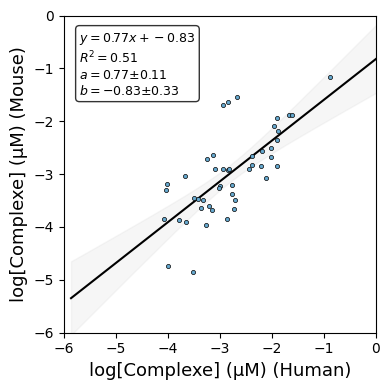

✅ Plot enregistré : output/Lin_Reg_Plots/HCK_log_complexome_Human_vs_Mouse.png


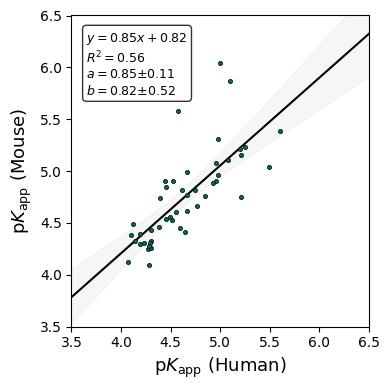

✅ Plot enregistré : output/Lin_Reg_Plots/HCK_pKapp_Human_vs_Mouse.png


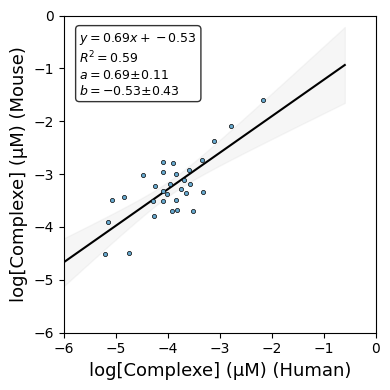

✅ Plot enregistré : output/Lin_Reg_Plots/SRC_log_complexome_Human_vs_Mouse.png


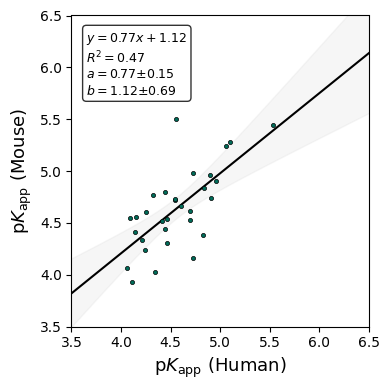

✅ Plot enregistré : output/Lin_Reg_Plots/SRC_pKapp_Human_vs_Mouse.png


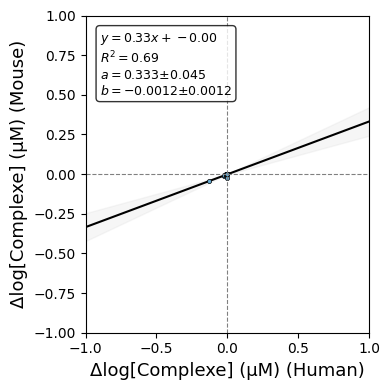

✅ Plot enregistré : output/Lin_Reg_Plots/SRC_minus_HCK_delta_complexome_Human_vs_Mouse.png


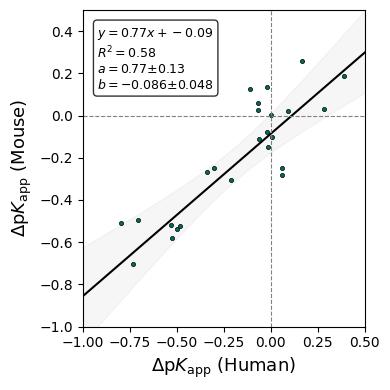

✅ Plot enregistré : output/Lin_Reg_Plots/SRC_minus_HCK_delta_pKapp_Human_vs_Mouse.png


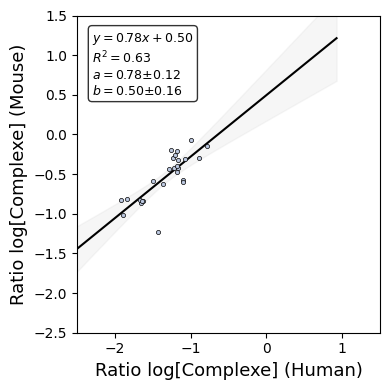

✅ Plot enregistré : output/Lin_Reg_Plots/SRC_vs_HCK_ratio_log_complexome_Human_vs_Mouse.png


In [ ]:
df_path = "output/merged.csv"
df = read_csv_file(df_path, header=[0, 1, 2])  

# Define output directory
output = "output/Linear_regression"

df = analyze_and_plot_correlation(df, annotate_genes=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn2

import seaborn as sns
import os
import subprocess
import math
from scipy.optimize import curve_fit
from scipy import stats

try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc


######################### Linear Regression Plot ################################
def analyze_and_plot_correlation(csv_file, output_file_prefix, species_x, col_x, species_y, col_y, graph_type, title, annotate_genes=False):

    """
    Process data, perform linear regression analysis, and create correlation plots.
    
    Parameters:
        csv_file (str): Path to CSV file with multi-level headers
        output_file_prefix (str): Prefix for the output image file
        species_x (str): Species for x-axis data ('Human' or 'Mouse')
        col_x (str): Column name for x-axis data
        species_y (str): Species for y-axis data ('Human' or 'Mouse')
        col_y (str): Column name for y-axis data
        title (str): Plot title
        graph_type (str): Type of data being plotted ('affinity', 'delta_pKapp', 'log_complexome', etc.)
        annotate_genes (bool): Whether to annotate points with gene IDs
    
    Returns:
        None: Displays and saves the plot
    """

 # Load data with multi-level headers
    data = pd.read_csv(csv_file, header=[0, 1])

    # Access columns with (species, column_name) tuples
    x_col = (species_x, col_x)
    y_col = (species_y, col_y)

    # Remove rows with missing values
    data_clean = data.dropna(subset=[x_col, y_col])
    if data_clean.empty:
        print(f"No valid data for correlation: {species_y} {col_y} vs {species_x} {col_x}.")
        return

    # Extract values for analysis
    x = data_clean[x_col].values
    y = data_clean[y_col].values
    n = len(y)

    # Define linear function for fitting
    def linear_function(x, a, b):
        return a * x + b

    # Perform curve fitting
    popt, pcov = curve_fit(linear_function, x, y)
    a, b = popt[0], popt[1]
    # Calculate R²
    r2 = 1.0 - (sum((y - linear_function(x, a, b)) ** 2) / ((n - 1.0) * np.var(y, ddof=1)))
    # Calculate uncertainty
    a_unc, b_unc = unc.correlated_values(popt, pcov)

    # Generate points for plotting the fit
    px = np.linspace(min(x.min(), y.min()) - 1, max(x.max(), y.max()) + 1, 1000)
    py = a_unc * px + b_unc
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)

    # Calculate prediction bands    
    def calculate_prediction_bands(x, xd, yd, p, func, conf=0.95):
        alpha = 1.0 - conf
        N = xd.size
        var_n = len(p)
        q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
        se = np.sqrt(1. / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
        sx = (x - xd.mean()) ** 2
        sxd = np.sum((xd - xd.mean()) ** 2)
        yp = func(x, *p)
        dy = q * se * np.sqrt(1.0 + (1.0 / N) + (sx / sxd))
        lpb, upb = yp - dy, yp + dy
        return lpb, upb

    lower_pred_band, upper_pred_band = calculate_prediction_bands(px, x, y, popt, linear_function)

    # Create the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(px, nom, c='black', label='Fit')
    ax.fill_between(px, nom - 1.96 * std, nom + 1.96 * std, color='lightgray', alpha=0.2, label='95% CI')

    # Set point color based on graph type
    point_color = {
        'affinity_intra': '#016c59',
        'affinity_inter': '#016c59',
        'delta_pKapp': '#016c59',
        'log_complexome': '#67a9cf',
        'delta_complexome': '#67a9cf'
    }.get(graph_type, "#4F61C5")

    ax.plot(x, y, 'o', color=point_color, markersize=3, markeredgecolor='black', markeredgewidth=0.5)

# Annotate points with gene IDs if requested
    if annotate_genes:
        gene_col = (species_x, 'Gene_ID')
        if gene_col in data_clean.columns:
            for i, row in data_clean.iterrows():
                ax.annotate(row[gene_col], (row[x_col], row[y_col]), fontsize=4, alpha=0.7)

    # Axes config + labels
    label_map = {
        'affinity_intra': (r'p$\it{K}_{\rm app}$ (HCK)', r'p$\it{K}_{\rm app}$ (SRC)', [3.5, 6.5], [3.5, 6.5]),
        'affinity_inter': (r'p$\it{K}_{\rm app}$ (Mouse)', r'p$\it{K}_{\rm app}$ (Human)', [3.5, 6.5], [3.5, 6.5]),
        'delta_pKapp': (r'Δp$\it{K}_{\rm app}$ (Mouse)', r'Δp$\it{K}_{\rm app}$ (Human)', [-1.0, 0.5], [-1.0, 0.5]),
        'log_complexome': ('log[Complexe] (μM, HCK)', 'log[Complexe] (μM, SRC)', [-6, 0], [-6, 0]),
        'log_ratio_complexome': ('Ratio[complexe](Mouse)', 'Ratio[complexe](Human)', [-2, 1], [-2, 0])
    }
    
    if graph_type in label_map:
        xlab, ylab, xlim, ylim = label_map[graph_type]
        ax.set_xlabel(xlab, fontsize=15)
        ax.set_ylabel(ylab, fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if 'delta' in graph_type:
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
            ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

    # Insert regression statistics
    def extract_bait(col_name):
        for bait in ['SRC', 'HCK']:
            if bait in col_name:
                return bait
        return ''

    bait_x = extract_bait(col_x)
    bait_y = extract_bait(col_y)

    stat_text = (
        f"{species_y} {bait_y} vs {species_x} {bait_x}\n"
        f"$y = {a:.2f}x + {b:.2f}$\n"
        f"$R^2 = {r2:.2f}$\n"
        f"$a = {a_unc:.2uP}$\n"
        f"$b = {b_unc:.2uP}$"
    )
    ax.text(0.05, 0.95, stat_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

    plt.tight_layout()

    # Save the plot
    os.makedirs("output", exist_ok=True)
    output_path = f'output/Lin_Reg_Plots/{output_file_prefix}.png'
    plt.savefig(output_path, dpi=600)
    print(f"Plot saved to: {output_path}")
    plt.show()
